In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import en_core_web_md
import spacy
from scipy.spatial.distance import cosine
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV,LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
data = pd.read_csv("reddit_worldnews_start_to_2016-11-22.csv", encoding='latin-1')
nlp = en_core_web_md.load()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Add a new column to contain 'year'
data['year']='2008'
for i in data.index:
    data.at[i,'year'] = data.at[i,'date_created'][:4]
data.groupby(['year']).mean()

,time_created,up_votes,down_votes,over_18
year,,,,
2008,1.216517e+09,15.823906,0.0,0.000267
2009,1.243837e+09,25.697511,0.0,0.000438
2010,1.278120e+09,38.427444,0.0,0.000257
2011,1.308658e+09,53.979581,0.0,0.001543
2012,1.342873e+09,92.048355,0.0,0.000516
2013,1.373529e+09,91.272569,0.0,0.000918
2014,1.404038e+09,119.458372,0.0,0.000456
2015,1.436001e+09,161.502077,0.0,0.000528
2016,1.465642e+09,182.005654,0.0,0.000513


We can easily see that the number of up_votes were rising through time. The reason for this is that Internet and Reddit were becoming more and more popular during this period (2008-2016). To eliminate the influence of time, we add "popular" label based on whether the up votes are in the top 5 percentile in every year's posts. 

# Labeling

In [3]:
# temp is a dict that contains the 95% cutoff of each year
temp={}
for i in range(2008,2017):
    temp[str(i)] = np.percentile(data[data['year']==str(i)]['up_votes'],95)

# Mark hot articles
data['label']=0
for i in data.index:
    if data.at[i,'up_votes'] >= temp[data.at[i,'year']]:
        data.at[i,'label']=1

In [4]:
print('# of hot articles: ', len(data[data['label']==1]))
print('# of non-hot articles: ', len(data[data['label']==0]))

# of hot articles:  25495
# of non-hot articles:  483741


# Preprocessing

In [5]:
# Preprocess the reviews (tokenizing, lemmatization, removing stopwords)
stop_words = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

def preprocessing(titles):
    filtered_titles = []
    for title in titles:
        title = title.lower()
        token_list = word_tokenize(title) # Tokenize
        filtered_token = [t for t in token_list if not t in stop_words] # Remove stopwords
        for i in range(len(filtered_token)):
            filtered_token[i] = lemmatizer.lemmatize(filtered_token[i]).strip(string.punctuation) # Lemmatization
        filtered_titles.append(" ".join(filtered_token))
    return filtered_titles

# TF-IDF weighted word2vec

In [6]:
# TF-IDF vectorizer
filtered_corpus = preprocessing(data["title"])
vectorizer = TfidfVectorizer(ngram_range=(1,1),
                             token_pattern=r'\b[a-zA-Z]{3,}\b',
                             max_df = 0.4, max_features = 2000) # only use first 2000 features because of 
                                                                # computatioal complexity later on

# vectorize the corpus
vector = vectorizer.fit_transform(filtered_corpus)

In [7]:
# TF-IDF matrix
tfidf_matrix = pd.DataFrame(vector.toarray(), columns = vectorizer.get_feature_names())
tfidf_matrix.head()

,abbas,abbott,abducted,abe,able,abortion,abroad,abu,abuse,accept,...,yemeni,yet,york,young,youth,youtube,zealand,zika,zimbabwe,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Word embeddings for each word in the column index of TF-IDF matrix
word2vec = [np.array(nlp(i).vector) for i in tfidf_matrix.columns]

In [9]:
# For each title, use each word's TF-IDF mutliply by its word embeddings vector and sum all the word vectors
# The result is an unweighted matrix for each title
unweighted_matrix = pd.DataFrame(np.dot(tfidf_matrix,np.array(word2vec)))
unweighted_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.912060,0.486792,0.476928,0.289893,0.054770,-0.870862,-0.268372,0.243633,0.638600,3.758917,...,0.147540,-0.250236,-0.509609,0.120965,0.368058,0.258011,-0.647812,-0.213497,0.221647,0.039148
1,-0.324209,-0.390879,-0.141281,0.468408,0.106328,0.084631,-0.485883,0.411318,0.092061,3.285786,...,0.568110,0.480141,0.255341,0.012618,-0.005795,-0.604799,-0.348221,0.065231,-0.195351,-0.358770
2,-0.392182,0.212705,0.292572,-0.265595,0.723275,-0.399778,-0.584884,0.070501,-0.410889,2.268124,...,0.122901,0.364871,-0.286764,-0.455900,0.556184,-0.654148,-0.201398,0.354193,-0.320886,0.658890
3,-0.495490,0.646893,-0.114675,-0.209844,-0.494770,-0.815250,-0.022099,-0.126436,0.217735,6.272498,...,-0.395701,0.316228,-0.125113,-0.427662,0.136894,-0.184926,-0.489197,-0.181203,0.021290,0.072146
4,-0.521825,0.040879,0.591420,0.060628,0.589623,0.026628,-0.254125,0.444144,-0.203941,4.084317,...,-0.188162,0.022798,0.389346,-0.072245,-0.124132,0.184864,0.015786,0.147740,-0.223388,0.561387


In [10]:
# For each title, use unweighted matrix divided by the sum of that title's TF-IDF to get weighted word2vec matrix
# The result is our final word2vec matrix
final_w2v = unweighted_matrix.div(tfidf_matrix.sum(axis=1), axis=0)
final_w2v = final_w2v.fillna(0)
final_w2v.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.465222,0.248302,0.243271,0.147868,0.027937,-0.444208,-0.136891,0.124272,0.325736,1.917342,...,0.075257,-0.127640,-0.259941,0.061702,0.187738,0.131606,-0.330435,-0.108900,0.113058,0.019968
1,-0.189500,-0.228469,-0.082579,0.273784,0.062149,0.049467,-0.283999,0.240415,0.053810,1.920541,...,0.332060,0.280642,0.149247,0.007375,-0.003387,-0.353505,-0.203535,0.038127,-0.114182,-0.209701
2,-0.197132,0.106917,0.147062,-0.133502,0.363557,-0.200950,-0.293994,0.035438,-0.206535,1.140080,...,0.061777,0.183404,-0.144143,-0.229160,0.279568,-0.328809,-0.101234,0.178036,-0.161294,0.331193
3,-0.222323,0.290256,-0.051454,-0.094156,-0.222000,-0.365797,-0.009915,-0.056731,0.097696,2.814425,...,-0.177548,0.141889,-0.056137,-0.191889,0.061423,-0.082975,-0.219499,-0.081305,0.009553,0.032371
4,-0.301983,0.023657,0.342258,0.035086,0.341218,0.015410,-0.147064,0.257029,-0.118022,2.363621,...,-0.108891,0.013193,0.225317,-0.041809,-0.071836,0.106982,0.009136,0.085498,-0.129276,0.324879


In [11]:
# Add label to final_w2v
final_w2v["label"] = np.array(data["label"])
final_w2v.shape

(509236, 301)

# Divide into training and testing

In [12]:
# Random split train(70%) and test(30%)
reddit_train, reddit_test, y_train, y_test = train_test_split(
    final_w2v.iloc[:,:-1],
    final_w2v["label"],
    test_size=0.3,
    random_state=1)

# Additional Variable - hot_author

In [13]:
### author = 1 if he/she had writen a hot article (in train dataset)
author=set()
for i in final_w2v.index:
    if final_w2v.at[i,'label']==1:
        author.add(data.at[i,'author'])
        
reddit_train['hot_author']=0
reddit_test['hot_author']=0
for i in reddit_train.index:
    if data.at[i,'author'] in author:
        reddit_train.at[i,'hot_author']=1
for i in reddit_test.index:
    if data.at[i,'author'] in author:
        reddit_test.at[i,'hot_author']=1

In [14]:
# Append w2v and author variable together
final_variables = pd.DataFrame(np.concatenate((reddit_train,reddit_test)), columns = reddit_train.columns)

In [15]:
# keep 90% of original information
pca = PCA(n_components = 0.9)
pca_features = pca.fit_transform(np.array(final_variables))
pca_df = pd.DataFrame(pca_features)
pca_features.shape

(509236, 141)

In [16]:
# Get train and test independent variables
train_row = len(reddit_train)
test_row = len(reddit_test)
X_train = pca_df[:int(train_row)]
X_test = pca_df[-int(test_row):]

In [17]:
# Logistic Regression
lr = LogisticRegressionCV(multi_class="ovr",fit_intercept=True,Cs=np.logspace(-2,2,20),cv=2,penalty="l2",solver="lbfgs",tol=0.01)
re = lr.fit(X_train,y_train)
train_prob=re.predict_proba(X_train)
test_prob=re.predict_proba(X_test)
train_df = pd.DataFrame(train_prob,index=y_train.index,columns = ['prob', 'y'])
train_df['y']=y_train
test_df = pd.DataFrame(test_prob,index=y_test.index,columns = ['prob', 'y'])
test_df['y']=y_test

In [18]:
# Get the train FDR@5% of Logistic regression
k=0
cur=0
num=int(0.05*len(train_df.index))
for i in train_df.sort_values(by='prob').index:
    if cur<num:
        cur+=1
        k+=train_df.loc[i,'y']
# train
print('train FDR@5% of Logistic regression:', '{:.2%}'.format(k/sum(train_df['y'])))

train FDR@5% of Logistic regression: 16.99%


In [19]:
# Get the test FDR@5% of Logistic regression
k=0
cur=0
num=int(0.05*len(test_df.index))
for i in test_df.sort_values(by='prob').index:
    if cur<num:
        cur+=1
        k+=test_df.loc[i,'y']
# test
print('test FDR@5% of Logistic regression:', '{:.2%}'.format(k/sum(test_df['y'])))

test FDR@5% of Logistic regression: 17.05%


# Gradient Boosting

In [20]:
# GBDT
gbm = GradientBoostingClassifier(random_state=10)
gbm.fit(X_train,y_train)
train_prob=gbm.predict_proba(X_train)
test_prob=gbm.predict_proba(X_test)
train_df = pd.DataFrame(train_prob,index=y_train.index,columns = ['prob', 'y'])
train_df['y']=y_train
test_df = pd.DataFrame(test_prob,index=y_test.index,columns = ['prob', 'y'])
test_df['y']=y_test

In [21]:
# Get the train FDR@5% of Gradient Boost Decision Tree
k=0
cur=0
num=int(0.05*len(train_df.index))
for i in train_df.sort_values(by='prob').index:
    if cur<num:
        cur+=1
        k+=train_df.loc[i,'y']
# train
print('train FDR@5% of GBDT:', '{:.2%}'.format(k/sum(train_df['y'])))

train FDR@5% of GBDT: 20.83%


In [22]:
# Get the test FDR@5% of Gradient Boost Decision Tree
k=0
cur=0
num=int(0.05*len(test_df.index))
for i in test_df.sort_values(by='prob').index:
    if cur<num:
        cur+=1
        k+=test_df.loc[i,'y']
# test
print('test FDR@5% of GBDT:', '{:.2%}'.format(k/sum(test_df['y'])))

test FDR@5% of GBDT: 18.45%


# Neural Network

In [23]:
# Neural Network
nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(21,6), random_state=1)
nn.fit(X_train, y_train)
train_prob=nn.predict_proba(X_train)
test_prob=nn.predict_proba(X_test)
train_df = pd.DataFrame(train_prob,index=y_train.index,columns = ['prob', 'y'])
train_df['y']=y_train
test_df = pd.DataFrame(test_prob,index=y_test.index,columns = ['prob', 'y'])
test_df['y']=y_test

In [24]:
# Get the train FDR@5% of Neural Network
k=0
cur=0
num=int(0.05*len(train_df.index))
for i in train_df.sort_values(by='prob').index:
    if cur<num:
        cur+=1
        k+=train_df.loc[i,'y']
# train
print('train FDR@5% of Neural Network:', '{:.2%}'.format(k/sum(train_df['y'])))

train FDR@5% of Neural Network: 27.93%


In [25]:
# Get the test FDR@5% of Neural Network
k=0
cur=0
num=int(0.05*len(test_df.index))
for i in test_df.sort_values(by='prob').index:
    if cur<num:
        cur+=1
        k+=test_df.loc[i,'y']
# test
print('test FDR@5% of Neural Network:', '{:.2%}'.format(k/sum(test_df['y'])))

test FDR@5% of Neural Network: 19.73%


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
fdr_graph=[]
k=0
cur=0
data_size=len(test_df.index)
for i in test_df.sort_values(by='prob').index:
    cur+=1
    k+=test_df.loc[i,'y']
    fdr_graph.append((k/sum(test_df['y']),cur/data_size))

In [28]:
fdr_graph_df=pd.DataFrame(fdr_graph,columns=['% Hot Posts Caught','% Total Population'])

In [29]:
fdr_graph_df.head()

,% Hot Posts Caught,% Total Population
0,0.000000,0.000007
1,0.000133,0.000013
2,0.000133,0.000020
3,0.000133,0.000026
4,0.000133,0.000033


[Text(0,0,'-20.00%'),
 Text(0,0,'0.00%'),
 Text(0,0,'20.00%'),
 Text(0,0,'40.00%'),
 Text(0,0,'60.00%'),
 Text(0,0,'80.00%'),
 Text(0,0,'100.00%'),
 Text(0,0,'120.00%')]

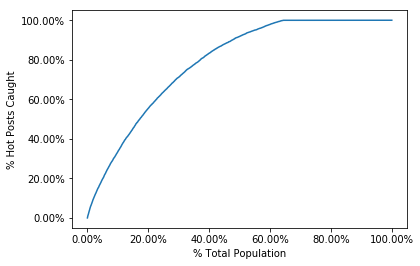

In [33]:
ax=sns.lineplot(x='% Total Population',y='% Hot Posts Caught',
            data=fdr_graph_df)
vals_y = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks()
ax.set_xticklabels(['{:,.2%}'.format(x) for x in vals_x])